# Forest management
In this Jupyter notebook we present some tools for the exploitation of .shp files in Python.
An .shp files contains geographical information: paths, fields, latitude...
Our study case is a forest with two .shp files: one with the paths inside the forest and one with the polygon defining the extend of the forest.

## Load .shp file with Python
The first thing to do is to load the .shp file with Python.
This can be done using the geopandas library (https://geopandas.org/index.html).
The geopandas library is based on the Pandas and Shapely libraries and it is designed to work with geographical data, including .shp files.

In [578]:
import geopandas as gp

We can use the read_file to load out data: the paths in the forest and the bounds of the forest.

In [579]:
paths_dataframe=gp.read_file('./inputs/34_cloisos.shp')
bounds_dataframe=gp.read_file('./inputs/34_contours.shp')

**field_dataframe** and **bounds_dataframe** are both GeoDataFrame.
This is a class with attributes and functions that can be found here : https://geopandas.org/reference/geopandas.GeoDataFrame.html

## Using a GeoDataFrame
Once the .shp files are loaded as GeoDataFrame one can use the build-in functions to perform different operations.
For example, we can already plot the forest and the paths. 

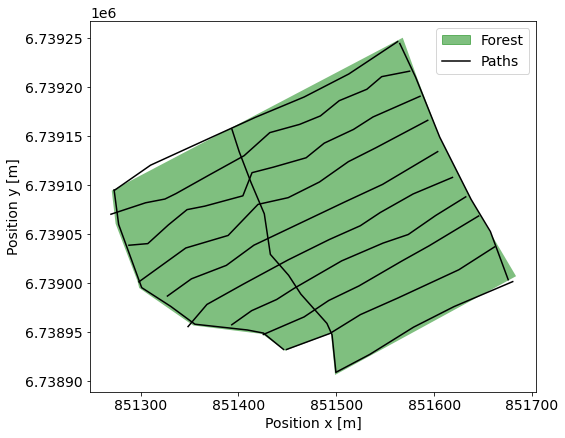

In [580]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
#Set the matplotlib fontsize
plt.rcParams.update({'font.size': 14})

fig,ax =plt.subplots(1,1,figsize=(8,8))
bounds_dataframe.plot(ax=ax,color='g',alpha=0.5)
paths_dataframe.plot(ax=ax,color='k')
ax.set_xlabel('Position x [m]')
ax.set_ylabel('Position y [m]')
# Legend
forest_patch = mpatches.Patch(color='g',alpha=0.5,label='Forest')
paths_patch= mlines.Line2D([], [], color='k',label='Paths')
ax.legend(handles=[forest_patch,paths_patch])

It is also possible to get informations about the paths and bounds as well. For example we can compute the forest area and its extend.

In [581]:
print('Forest area is equal to ', bounds_dataframe.area.values[0],'m²')
print('Forest extends are: \n',bounds_dataframe.bounds)

Forest area is equal to  80928.81658449229 m²
Forest extends are: 
            minx          miny           maxx          maxy
0  851270.60988  6.738906e+06  851683.591318  6.739250e+06


From the extend of the forest we can compute the size of the forest in x and y directions:

In [582]:
xmin,ymin,xmax,ymax=bounds_dataframe.bounds.values[0]
size_x=xmax-xmin
size_y=ymax-ymin

## Problem
Our problem is to map the minimum distance between any point in the forest and the closest path.
If a point is already at a distance less than 3m from a path, such point should not be considered.

### Defining the mesh
The first step is to create a mesh representing the forest.
The user can choose the mesh precision by adjusting the delta value that represents the pixel_size in meters.
For visual and computational speed purposes we set this value to 20 meters.

In [583]:
import numpy as np
delta=20
x = np.arange(xmin, xmax, delta)
y = np.arange(ymin, ymax, delta)
X, Y = np.meshgrid(x, y)

### Creation of a buffered version of the paths in the Forest

At this point we want to exclude all points that are at a distance lesser or equal to 3m from an existing path. 
We create a buffered version of the paths to ensure this conditon. It is necessary that the object representing the buffered version of the paths is unique and valid.

In [584]:
from shapely.geometry import MultiLineString
#Loop over all paths to create a list of all paths
paths_list=[path for path in paths_dataframe.geometry]
#Create a MultiLineString object that is the combination of all paths.
multi_path_buffered=MultiLineString(polygon_list)
#Creation of a paths_buffered that is a buffered version of the paths.
paths_buffered=gp.GeoSeries(multi_path_buffered)
paths_buffered=paths_buffered.buffer(3)
print('The buffered version is valid ?: ',paths_buffered.is_valid[0])

The buffered version is valid ?:  True


We can plot the original and buffered paths as well as the mesh to see what happened:

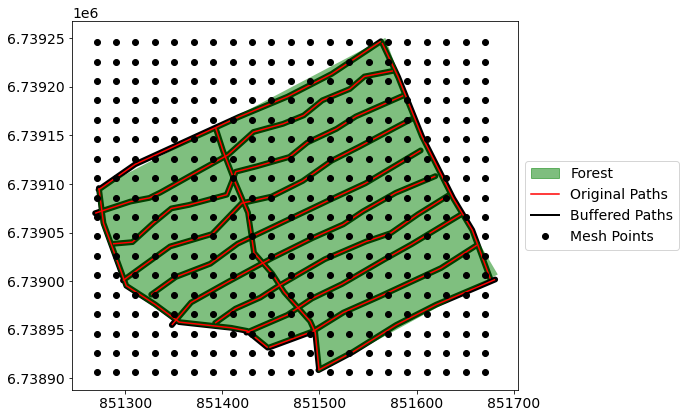

In [585]:
fig,ax =plt.subplots(1,1,figsize=(8,8))
ax.plot(X,Y,'ko')
paths_buffered.plot(ax=ax,color='k',label='Buffered paths')
paths_dataframe.plot(ax=ax,color='r',label='Original paths')
bounds_dataframe.plot(ax=ax,color='g',label='Bounds',alpha=0.5)
#Figure legends
forest_patch = mpatches.Patch(color='g',alpha=0.5,label='Forest')
paths_patch= mlines.Line2D([], [], color='r',label='Original Paths')
paths_buffered_patch= mlines.Line2D([], [], color='k',linewidth=2.,label='Buffered Paths')
mesh_patch=mlines.Line2D([], [], color='k',linewidth=0.,marker='o',label='Mesh Points')
ax.legend(handles=[forest_patch,paths_patch,paths_buffered_patch,mesh_patch],loc='center left', bbox_to_anchor=(1, 0.5))

The buffered paths are a thicker version of the original paths. Each black dots corresponds to a point in the mesh. Some points are outside the forest so they musn't be considered during the computation. Furthermore, the points that overlap with the buffered paths should not be considered either.

### Treatment of the mesh points
The code below loops over all mesh points, checks if the point is inside the forest and if so plots it in green. If the point is outside the forest it is plotted in red. Furthermore if a plot is inside the forest and overlaps with the buffered paths it is plotted as a blue circle.

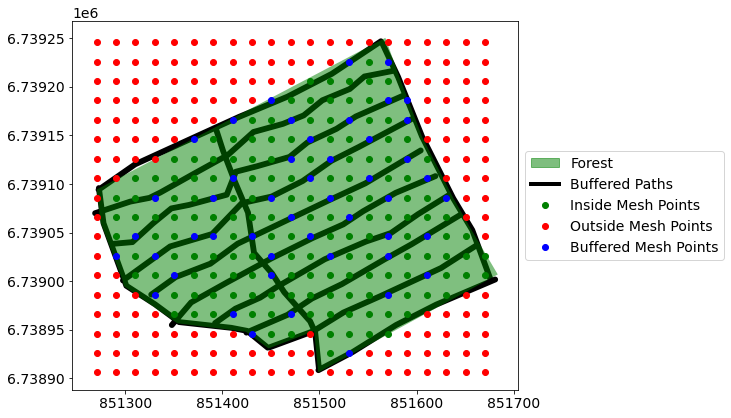

In [586]:
fig,ax=plt.subplots(1,1,figsize=(8,8))
#Loop over all points
for x_l in x:
    for y_l in y:
        #Create a Point from x_l and y_l coordinates
        cur_point=Point(x_l,y_l)
        #Check if the point is inside the forest.
        if cur_point.intersection(bounds_dataframe.geometry.values[0]).is_empty is False:
            #Check if the points overlaps with the buffered paths:
            if cur_point.intersection(paths_buffered.geometry.values[0]).is_empty is False:
                ax.plot(x_l,y_l,'bo')
            else:
                ax.plot(x_l,y_l,'go') 
        #The point is outside the forest.
        else:
            ax.plot(x_l,y_l,'ro')
#Plot the buffered paths and the forest.
paths_buffered.plot(ax=ax,color='k')
bounds_dataframe.plot(ax=ax,color='g',label='Bounds',alpha=0.5)
#Figure Legends
forest_patch = mpatches.Patch(color='g',alpha=0.5,label='Forest')
paths_buffered_patch= mlines.Line2D([], [], color='k',linewidth=4.,label='Buffered Paths')
mesh_in_patch=mlines.Line2D([], [], color='g',linewidth=0.,marker='o',label='Inside Mesh Points')
mesh_buf_patch=mlines.Line2D([], [], color='b',linewidth=0.,marker='o',label='Buffered Mesh Points')
mesh_out_patch=mlines.Line2D([], [], color='r',linewidth=0.,marker='o',label='Outside Mesh Points')
mesh_buffered_patch=mlines.Line2D([], [], color='b',linewidth=0.,marker='o',label='Buffered Mesh Points')
ax.legend(handles=[forest_patch,paths_buffered_patch,mesh_in_patch,mesh_out_patch,mesh_buffered_patch],loc='center left', bbox_to_anchor=(1, 0.5))

## Resolution of the problem
Now that we have seen how to selectively choose the correct mesh points, we create a final loop that computes for all green meshpoints the distance to the closest path and plot the result.

In [587]:
#Compute the number of points along each axis for the meshgrid
ny,nx=X.shape
#Instanciate the distance array
dist_array=np.zeros_like(X)
for j in range(nx):
    for i in range(ny):
        x_pos = X[i, j]
        y_pos = Y[i, j]
        point = gp.points_from_xy([x_pos],[y_pos])[0]
        # Make sure taht the point is in the forest and does not overlap with 
        #the buffered pathspoint
        if ((point.intersection(bounds_dataframe.geometry.values[0]).is_empty is False) and
                (point.intersection(paths_buffered.geometry.values[0]).is_empty is True)):
            closest_point = nearest_points(point, paths_shapely)[1]
            r_all = point.distance(closest_point)
            dist_array[i, j] = r_all
        else:
            dist_array[i, j] = None
#y axis is pointed downward in matplotlib, need to flip it back up.
dist_array = np.flipud(dist_array)

The final figure is plotted below

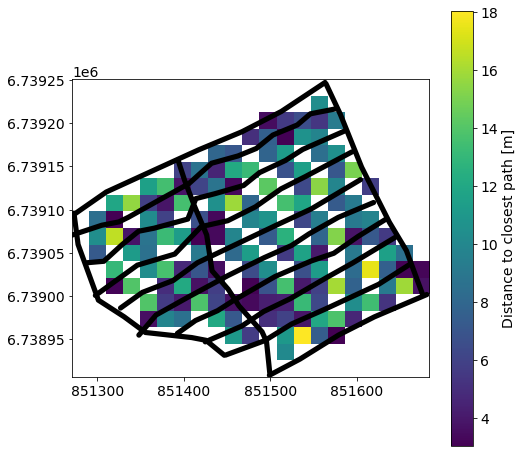

In [588]:
fig,ax=plt.subplots(1,1,figsize=(8,8))
distance_mapping=ax.imshow(dist_array,extent=[xmin,xmax,ymin,ymax])
#Colorbar
cbar=fig.colorbar(distance_mapping,ax=ax)
cbar.ax.set_ylabel('Distance to closest path [m]')
paths_buffered.plot(ax=ax,color='k')

In [589]:
# Code to automatically center the matplotlib figures
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")